> **Problem overview**

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset. You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import scientific computing library
import statsmodels.api as sm

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.read_csv('../input/train.csv', parse_dates=['date'], index_col='date')
df_test = pd.read_csv('../input/test.csv', parse_dates=['date'], index_col='date')

In [3]:
# visualize head of the training data
df_train.head(n=5)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
# visualize tail of the testing data
df_test.tail(n=5)

,id,store,item
date,,,
2018-03-27,44995,10,50
2018-03-28,44996,10,50
2018-03-29,44997,10,50
2018-03-30,44998,10,50
2018-03-31,44999,10,50


In [5]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train.insert(0, 'id', 0)
df_test.insert(df_test.shape[1] - 1, 'sales', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=False)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [7]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [8]:
# boxplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [9]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [10]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [11]:
# violinplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [12]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [13]:
# describe training and testing data
df_data.describe(include='all')

,id,store,item,sales,datatype
count,958000.000000,958000.000000,958000.000000,913000.000000,958000
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,training
freq,NaN,NaN,NaN,NaN,913000
mean,1056.865866,5.500000,25.500000,52.250287,NaN
std,5530.704311,2.872283,14.430877,28.801144,NaN
min,0.000000,1.000000,1.000000,0.000000,NaN
25%,0.000000,3.000000,13.000000,30.000000,NaN
50%,0.000000,5.500000,25.500000,47.000000,NaN
75%,0.000000,8.000000,38.000000,70.000000,NaN


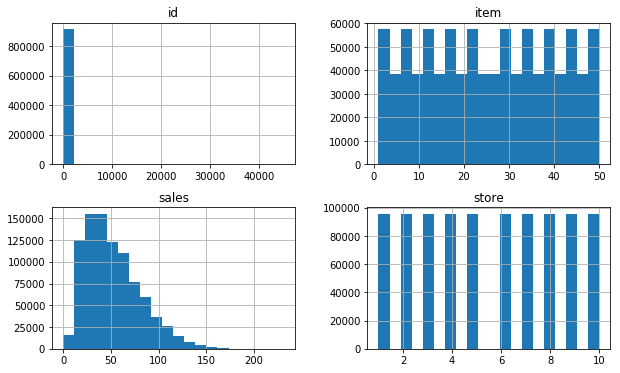

In [14]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [15]:
# feature extraction: sales
df_data['sales'] = np.log1p(df_data['sales'])

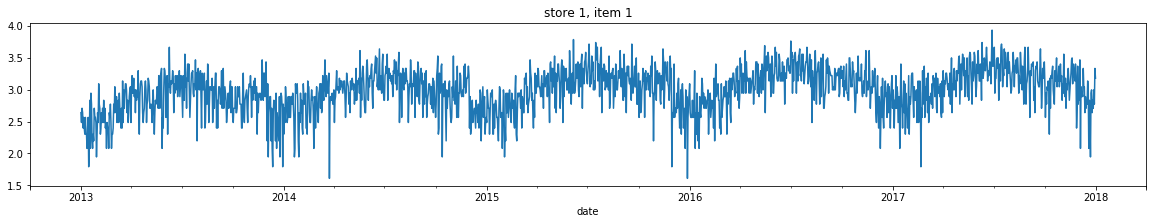

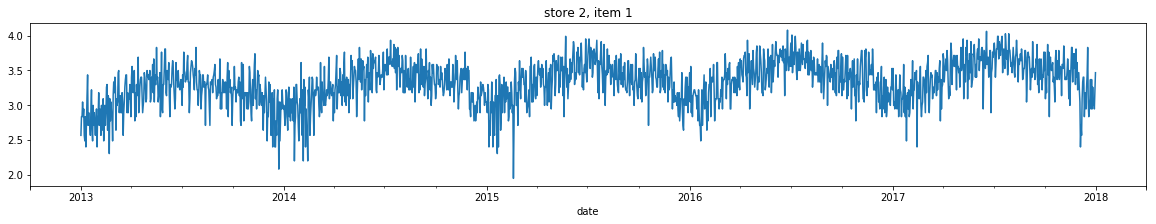

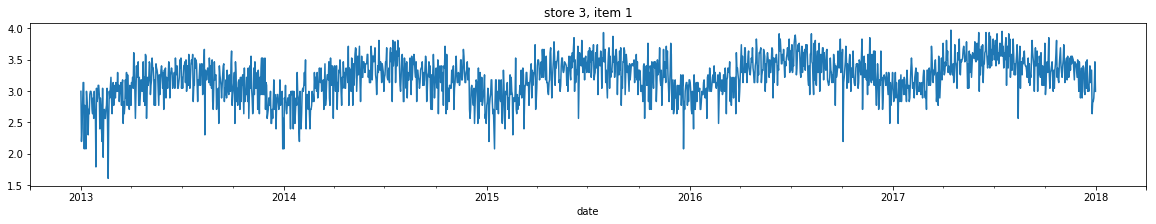

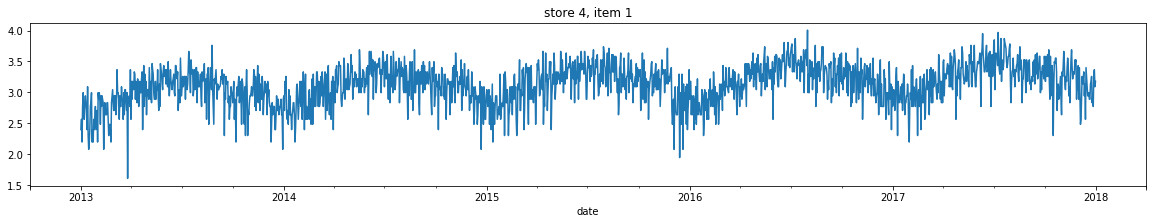

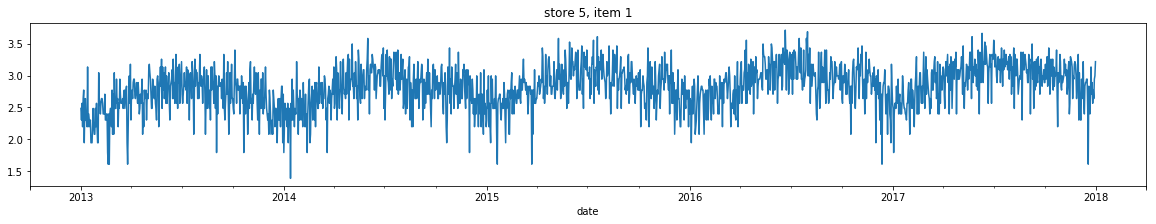

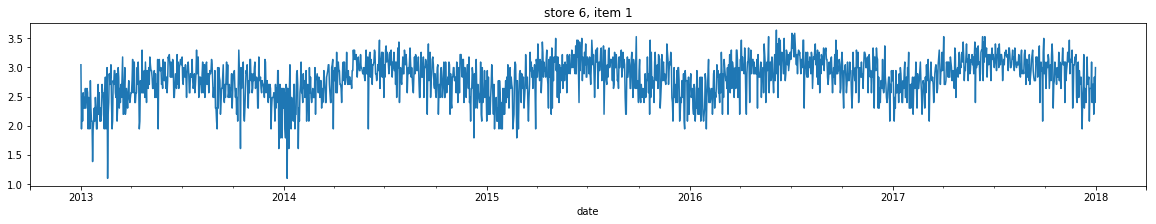

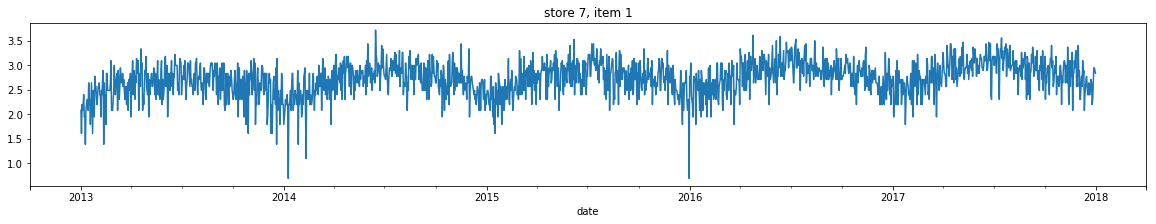

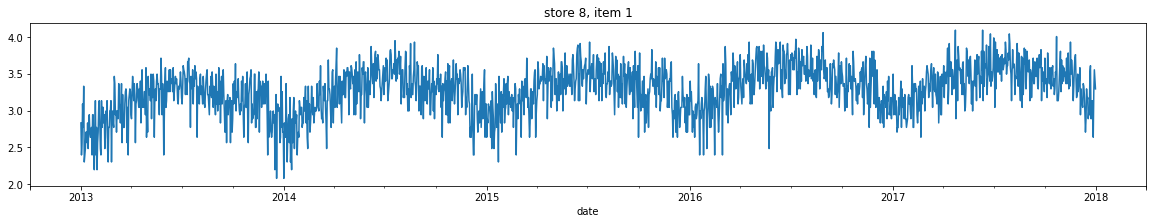

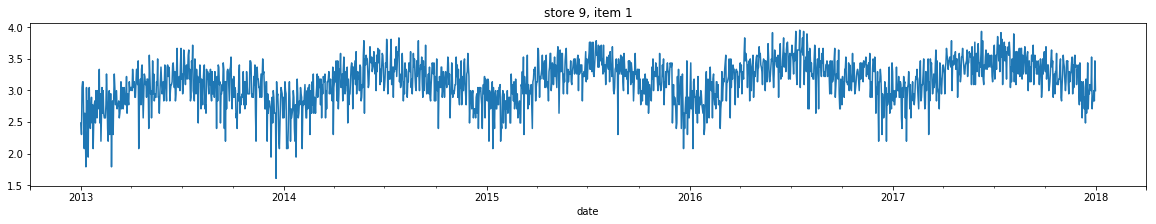

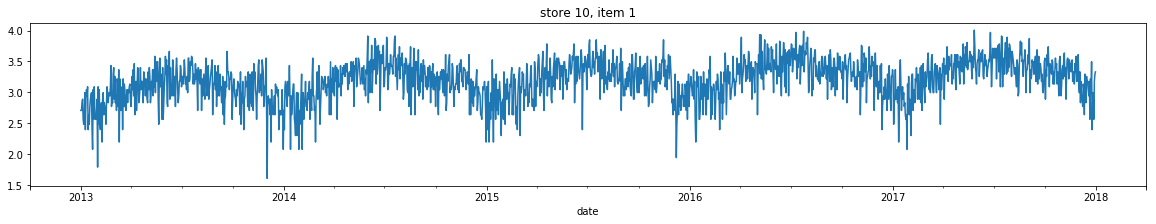

In [16]:
# feature exploration: season for store 1 to 10 and item 1
for i in range(1, 11):
    fig, axes = plt.subplots(figsize=(20, 3))
    _ = df_data.loc[(df_data['store'] == i) & (df_data['item'] == 1) & (df_data['datatype'] == 'training'), 'sales'].plot()
    axes.set_title('store %d, item %d' %(i, 1))

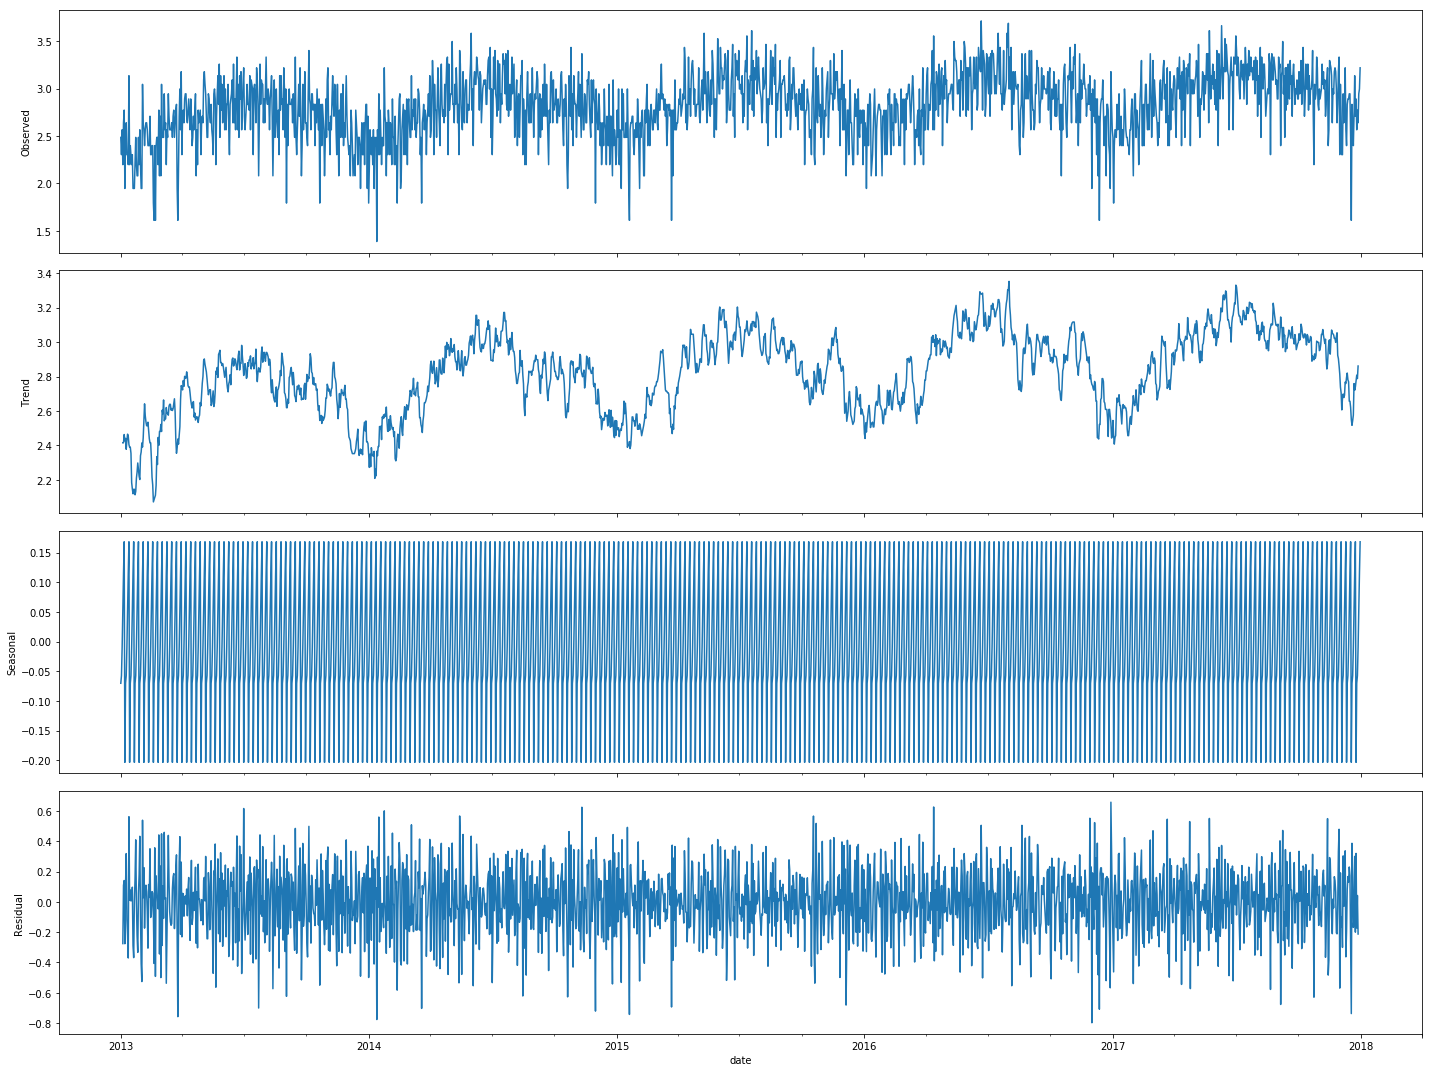

In [17]:
# feature exploration: seasonal decompose for store 5 and item 1
seasonal = sm.tsa.seasonal_decompose(df_data.loc[(df_data['store'] == 5) & (df_data['item'] == 1) & (df_data['datatype'] == 'training'), 'sales']).plot()
seasonal.set_figwidth(20)
seasonal.set_figheight(15)
plt.tight_layout(); plt.show()

In [18]:
# feature extraction: combination of keyword date
df_data['date'] = df_data.index
df_data['year'] = df_data['date'].dt.year
df_data['quarter'] = df_data['date'].dt.quarter
df_data['month'] = df_data['date'].dt.month
df_data['weekofyear'] = df_data['date'].dt.weekofyear
df_data['dayofweek'] = df_data['date'].dt.dayofweek

In [19]:
# feature extraction: statistic features for store, item and quarter
df_data['item_quarter_mean'] = df_data.groupby(['quarter', 'item'])['sales'].transform('mean')
df_data['store_quarter_mean'] = df_data.groupby(['quarter', 'store'])['sales'].transform('mean')
df_data['store_item_quarter_mean'] = df_data.groupby(['quarter', 'store', 'item'])['sales'].transform('mean')

In [20]:
# feature extraction: statistic features for store, item and month
df_data['item_month_mean'] = df_data.groupby(['month', 'item'])['sales'].transform('mean')
df_data['store_month_mean'] = df_data.groupby(['month', 'store'])['sales'].transform('mean')
df_data['store_item_month_mean'] = df_data.groupby(['month', 'store', 'item'])['sales'].transform('mean')

In [21]:
# feature extraction: statistic features for store, item and weekofyear
df_data['item_weekofyear_mean'] = df_data.groupby(['weekofyear', 'item'])['sales'].transform('mean')
df_data['store_weekofyear_mean'] = df_data.groupby(['weekofyear', 'store'])['sales'].transform('mean')
df_data['store_item_weekofyear_mean'] = df_data.groupby(['weekofyear', 'store', 'item'])['sales'].transform('mean')

In [22]:
# feature extraction: statistic features for store, item and dayofweek
df_data['item_dayofweek_mean'] = df_data.groupby(['dayofweek', 'item'])['sales'].transform('mean')
df_data['store_dayofweek_mean'] = df_data.groupby(['dayofweek', 'store'])['sales'].transform('mean')
df_data['store_item_dayofweek_mean'] = df_data.groupby(['dayofweek', 'store', 'item'])['sales'].transform('mean')

In [23]:
# feature extraction: shifted features for 45 days
df_data['store_item_shift45'] = df_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(45))
df_data['item_weekofyear_shift45_mean'] = df_data.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(13).mean())
df_data['store_weekofyear_shift45_mean'] = df_data.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(13).mean())

In [24]:
# feature extraction: shifted features for store, item and weekofyear shift 90 days
df_data['store_item_shift90'] = df_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(90))
df_data['item_weekofyear_shift90_mean'] = df_data.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(13).mean())
df_data['store_weekofyear_shift90_mean'] = df_data.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(13).mean())

In [25]:
# feature extraction: shifted features for store, item and weekofyear shift 180 days
df_data['store_item_shift180'] = df_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(180))
df_data['item_weekofyear_shift180_mean'] = df_data.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(26).mean())
df_data['store_weekofyear_shift180_mean'] = df_data.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(26).mean())

In [26]:
# feature extraction: shifted features for store, item and weekofyear shift 270 days
df_data['store_item_shift270'] = df_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(270))
df_data['item_weekofyear_shift270_mean'] = df_data.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(39).mean())
df_data['store_weekofyear_shift270_mean'] = df_data.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(39).mean())

In [27]:
# feature extraction: shifted features for store, item and weekofyear shift 365 days
df_data['store_item_shift365'] = df_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(365))
df_data['item_weekofyear_shift365_mean'] = df_data.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(52).mean())
df_data['store_weekofyear_shift365_mean'] = df_data.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(52).mean())

In [28]:
# feature extraction: fillna with 0
col_fillnas = ['store_item_shift45', 'store_item_shift90', 'store_item_shift180', 'store_item_shift365']
df_data[col_fillnas] = df_data[col_fillnas].fillna(0)

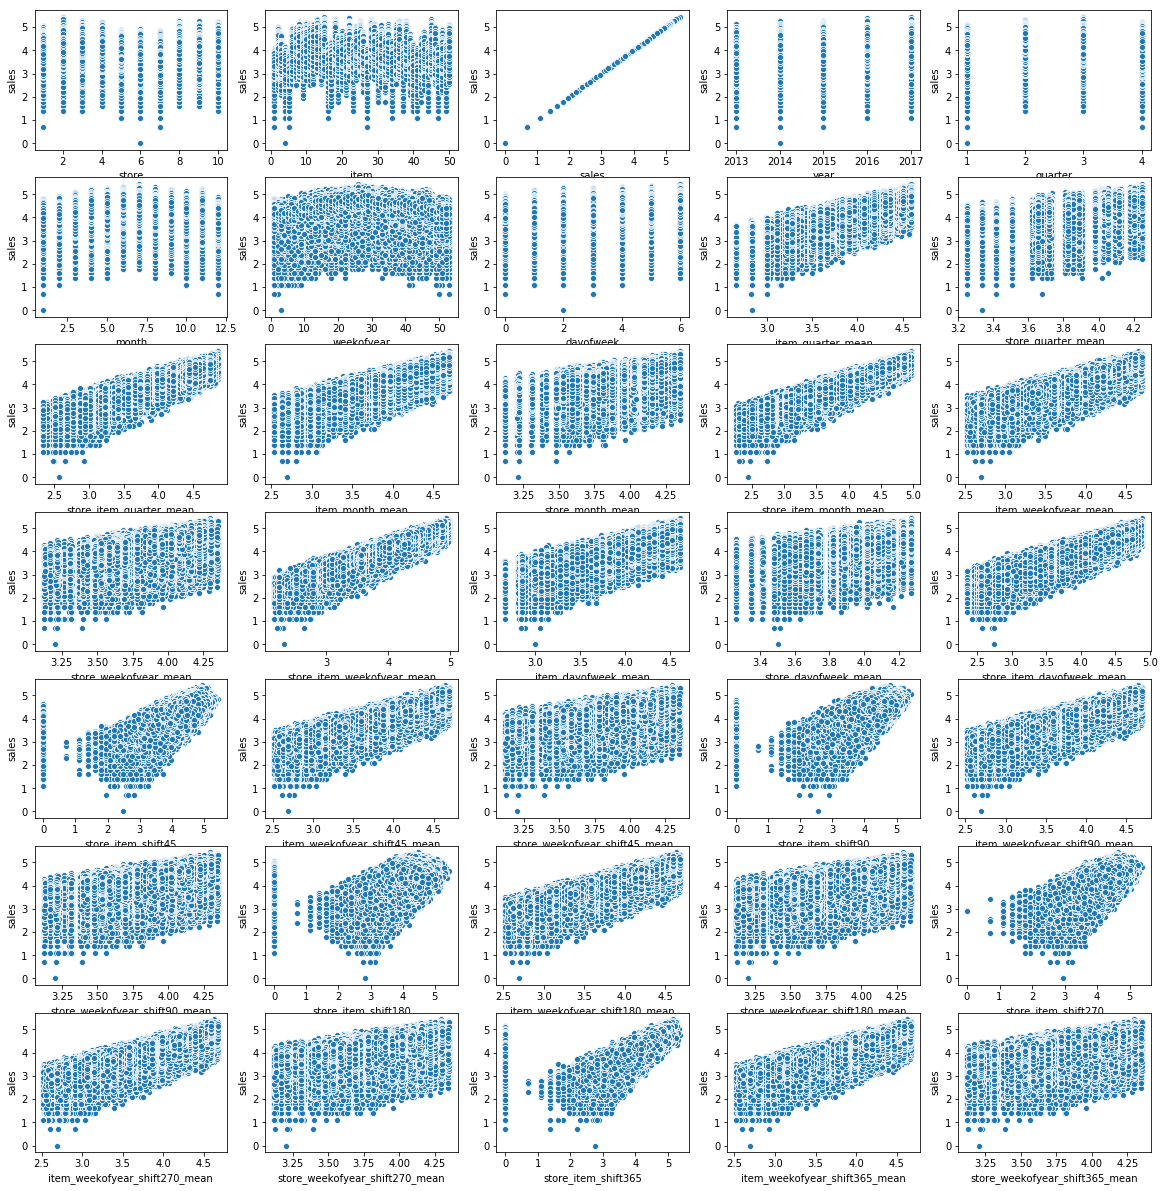

In [29]:
# feature exploration: sales
col_number = df_data.select_dtypes(include=['number']).columns.drop(['id']).tolist()
scatterplot(x=col_number, y='sales', data=df_data[df_data['datatype'] == 'training'], nrows=(len(col_number) - 1) // 5 + 1)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [30]:
# feature extraction: fillna with 0
df_data['sales'] = df_data['sales'].fillna(0)

In [31]:
# convert category codes for data dataframe
df_data = pd.get_dummies(df_data, columns=None, drop_first=True)

In [32]:
# describe data dataframe
df_data.describe(include='all')

,id,store,item,sales,date,year,quarter,month,weekofyear,dayofweek,item_quarter_mean,store_quarter_mean,store_item_quarter_mean,item_month_mean,store_month_mean,store_item_month_mean,item_weekofyear_mean,store_weekofyear_mean,store_item_weekofyear_mean,item_dayofweek_mean,store_dayofweek_mean,store_item_dayofweek_mean,store_item_shift45,item_weekofyear_shift45_mean,store_weekofyear_shift45_mean,store_item_shift90,item_weekofyear_shift90_mean,store_weekofyear_shift90_mean,store_item_shift180,item_weekofyear_shift180_mean,store_weekofyear_shift180_mean,store_item_shift270,item_weekofyear_shift270_mean,store_weekofyear_shift270_mean,store_item_shift365,item_weekofyear_shift365_mean,store_weekofyear_shift365_mean,datatype_training
count,958000.000000,958000.000000,958000.000000,958000.000000,958000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,823000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000,958000.000000
unique,NaN,NaN,NaN,NaN,1916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,2018-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2018-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1056.865866,5.500000,25.500000,3.640986,NaN,2015.141441,2.437891,6.311065,25.691023,3.000000,3.809461,3.809461,3.809461,3.809464,3.809464,3.809464,3.809473,3.809473,3.809473,3.820344,3.820344,3.820344,3.640986,3.802374,3.807114,3.640986,3.802374,3.807114,3.458841,3.798100,3.805375,3.802401,3.796213,3.805206,3.063989,3.791163,3.807389,0.953027
std,5530.704311,2.872283,14.430877,0.986195,NaN,1.519304,1.136235,3.504592,15.302475,1.998696,0.481115,0.261536,0.522519,0.492566,0.282029,0.533178,0.491636,0.280316,0.532813,0.469239,0.238899,0.511650,0.986195,0.490386,0.279542,0.986195,0.490386,0.279542,1.243016,0.489659,0.278949,0.578228,0.489122,0.278915,1.574213,0.488136,0.279569,0.211581
min,0.000000,1.000000,1.000000,0.000000,NaN,2013.000000,1.000000,1.000000,1.000000,0.000000,2.658959,3.251856,2.345750,2.538220,3.124189,2.259954,2.522766,3.120726,2.166747,2.667824,3.265190,2.356009,0.000000,2.522766,3.120726,0.000000,2.522766,3.120726,0.000000,2.522766,3.120726,0.000000,2.522766,3.120726,0.000000,2.522766,3.120726,0.000000
25%,0.000000,3.000000,13.000000,3.332205,NaN,2014.000000,1.000000,3.000000,12.000000,1.000000,3.427202,3.656283,3.421283,3.415491,3.628514,3.419079,3.411923,3.627979,3.418331,3.437750,3.660719,3.431273,3.332205,3.404232,3.624699,3.332205,3.404232,3.624699,3.258097,3.398540,3.622438,3.401197,3.395521,3.622085,2.890372,3.393734,3.625700,1.000000


In [33]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958000 entries, 2013-01-01 to 2018-03-31
Data columns (total 38 columns):
id                                958000 non-null int64
store                             958000 non-null int64
item                              958000 non-null int64
sales                             958000 non-null float64
date                              958000 non-null datetime64[ns]
year                              958000 non-null int64
quarter                           958000 non-null int64
month                             958000 non-null int64
weekofyear                        958000 non-null int64
dayofweek                         958000 non-null int64
item_quarter_mean                 958000 non-null float64
store_quarter_mean                958000 non-null float64
store_item_quarter_mean           958000 non-null float64
item_month_mean                   958000 non-null float64
store_month_mean                  958000 non-null float64
store_item_m

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

In [34]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_data[df_data['datatype_training'] == 1].corr()
fig, axes = plt.subplots(figsize=(200, 150))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [35]:
# symmetric mean absolute percentage error (mape) function
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    condition = (y_true > 0) & (y_pred > 0)
    return np.mean(2 * np.abs((y_pred[condition] - y_true[condition])) / (np.abs(y_pred[condition]) + np.abs(y_true[condition]))) * 100

In [36]:
# symmetric mean absolute percentage error (mape) scoring function
def symmetric_mean_absolute_percentage_error_scoring(model, x, y):
    y_pred = model.predict(x)
    return symmetric_mean_absolute_percentage_error(y, y_pred)

In [37]:
# select all features
x = df_data[df_data['datatype_training'] == 1].drop(['id', 'sales', 'date', 'datatype_training'], axis=1)
y = df_data.loc[df_data['datatype_training'] == 1]['sales']

In [38]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

In [39]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(booster='gbtree', learning_rate=0.1, n_estimators=1000, objective='reg:linear', random_state=58,
                                colsample_bytree=0.9, max_depth=5, reg_alpha=0.1, reg_lambda=0.9, subsample=0.9)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, early_stopping_rounds=100, eval_set=[(x_validate, y_validate)], verbose=False,
                 callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_mape = symmetric_mean_absolute_percentage_error(y_validate, model_xgbreg_ypredict)
print('xgboost regression\n  symmetric mean absolute percentaged error: %0.4f' %model_xgbreg_mape)

[0]	validation_0-rmse:3.0332
[100]	validation_0-rmse:0.159602
[200]	validation_0-rmse:0.159211
[300]	validation_0-rmse:0.159082
[400]	validation_0-rmse:0.159057
xgboost regression
  symmetric mean absolute percentaged error: 3.4104


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [40]:
# model selection
final_model = model_xgbreg

# prepare testing data and compute the observed value
x_test = df_data[df_data['datatype_training'] == 0].drop(['id', 'sales', 'date', 'datatype_training'], axis=1)
y_test = pd.DataFrame(final_model.predict(x_test),
                      columns=['sales'], index=df_data.loc[df_data['datatype_training'] == 0, 'id'])
y_test['sales'] = np.expm1(y_test['sales'])

In [41]:
# summit the results
out = pd.DataFrame({'id': y_test.index, 'sales': y_test['sales']})
out.to_csv('submission.csv', index=False)